In [9]:
import numpy as np
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import io
import os
import random
from PIL import Image
import albumentations as A
import tensorflow as tf
from tensorflow_datasets import load
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D,
                                     Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer,
                                     BatchNormalization, Rescaling,
                                     Resizing, Input, Dropout,
                                     RandomFlip, RandomContrast,
                                     Rescaling, RandomRotation, Rescaling, Resizing, Embedding, MultiHeadAttention,
                                     LayerNormalization, Add, Permute)
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping,
                                        LearningRateScheduler, ModelCheckpoint, 
                                        ReduceLROnPlateau)
from tensorflow.keras.regularizers import L1, L2
from tensorflow.train import BytesList, FloatList, Int64List     
from tensorflow.train import Example, Features, Feature
#import tensorflow_model_optimization as tfmot
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
#import tf2onnx
#import onnxruntime as rt
#import fastapi

In [18]:
train_directory = r"E:\python\segmentation\Computer Vision\Data\Emotions Dataset\Emotions Dataset\train"
validation_directory = r"E:\python\segmentation\Computer Vision\Data\Emotions Dataset\Emotions Dataset\test"
CLASS_NAMES = ['angry', 'happy', 'sad']

CONFIGURATION={
    'BATCH_SIZE':32,
    'IM_SIZE':256,
    'LEARNING_RATE':0.001,   
    "N_EPOCHS":20,
    'DROPOUT_RATE':0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS':6,
    'KERNEL_SIZE':3,
    'N_STRIDES':1,
    'POOL_SIZE':2,
    'PATCH_SIZE':16,
    'N_DENSE_1':1024,
    'N_DENSE_2':128,
    'NUM_CLASSES':3,
    'CLASS_NAMES':["angry", "happy", "sad"]
    
}

# Dataset Loading

In [21]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
    #subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 6799 files belonging to 3 classes.


In [23]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=1,#CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99, 
    #subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2278 files belonging to 3 classes.


In [25]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 89.      ,  89.      ,  89.      ],
         [ 91.4375  ,  91.4375  ,  91.4375  ],
         [ 85.8125  ,  85.8125  ,  85.8125  ],
         ...,
         [ 26.6875  ,  26.6875  ,  26.6875  ],
         [ 26.      ,  26.      ,  26.      ],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 79.25    ,  79.25    ,  79.25    ],
         [ 86.30859 ,  86.30859 ,  86.30859 ],
         [ 87.89453 ,  87.89453 ,  87.89453 ],
         ...,
         [ 25.875   ,  25.875   ,  25.875   ],
         [ 25.339844,  25.339844,  25.339844],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 71.5     ,  71.5     ,  71.5     ],
         [ 79.625   ,  79.625   ,  79.625   ],
         [ 87.60156 ,  87.60156 ,  87.60156 ],
         ...,
         [ 24.570312,  24.570312,  24.570312],
         [ 23.253906,  23.253906,  23.253906],
         [ 24.625   ,  24.625   ,  24.625   ]],

        ...,

        [[170.      , 170.      ,

# Dataset Visualization

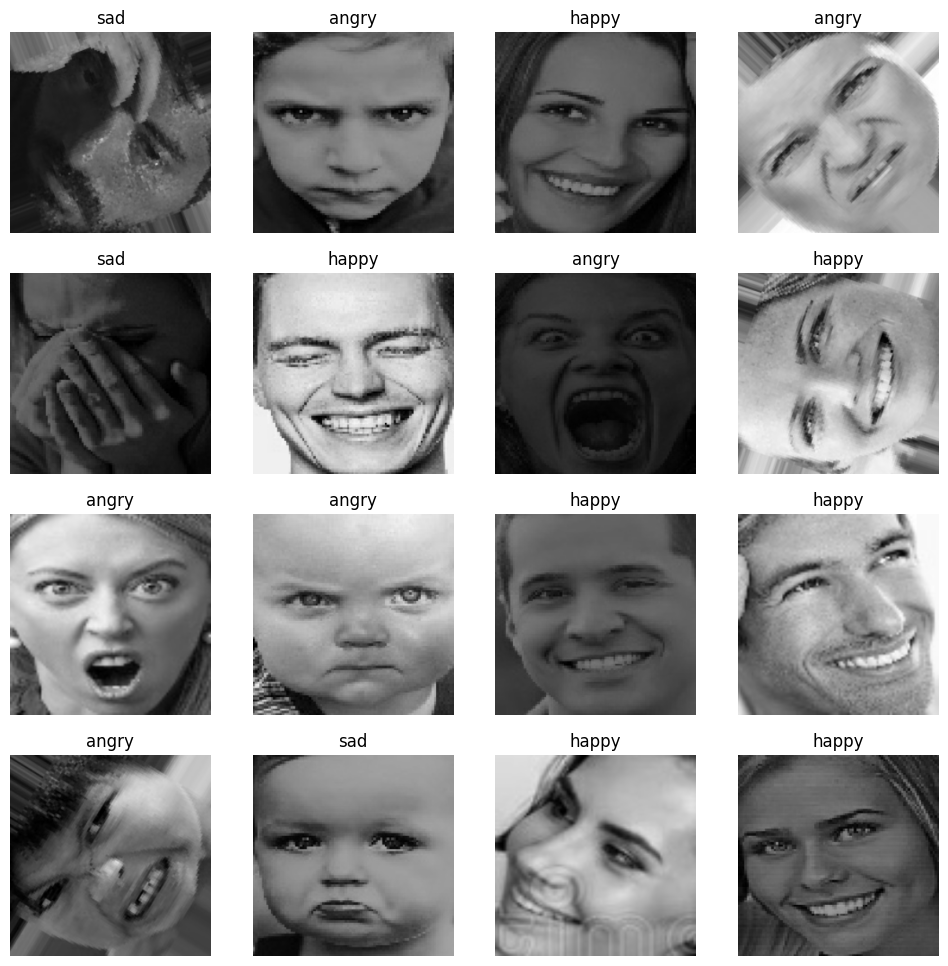

In [27]:
plt.figure(figsize=(12, 12))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
        plt.axis("off")

# Data Augmentation

In [35]:
# This limit rotation does not perform well for our model so i change it in next cell

# tf.keras.layer Augment
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501),),
    RandomFlip(mode="horizontal",),
    RandomContrast(factor=0.1),
])

In [37]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

Training with augment_layer

In [40]:
train_augment_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

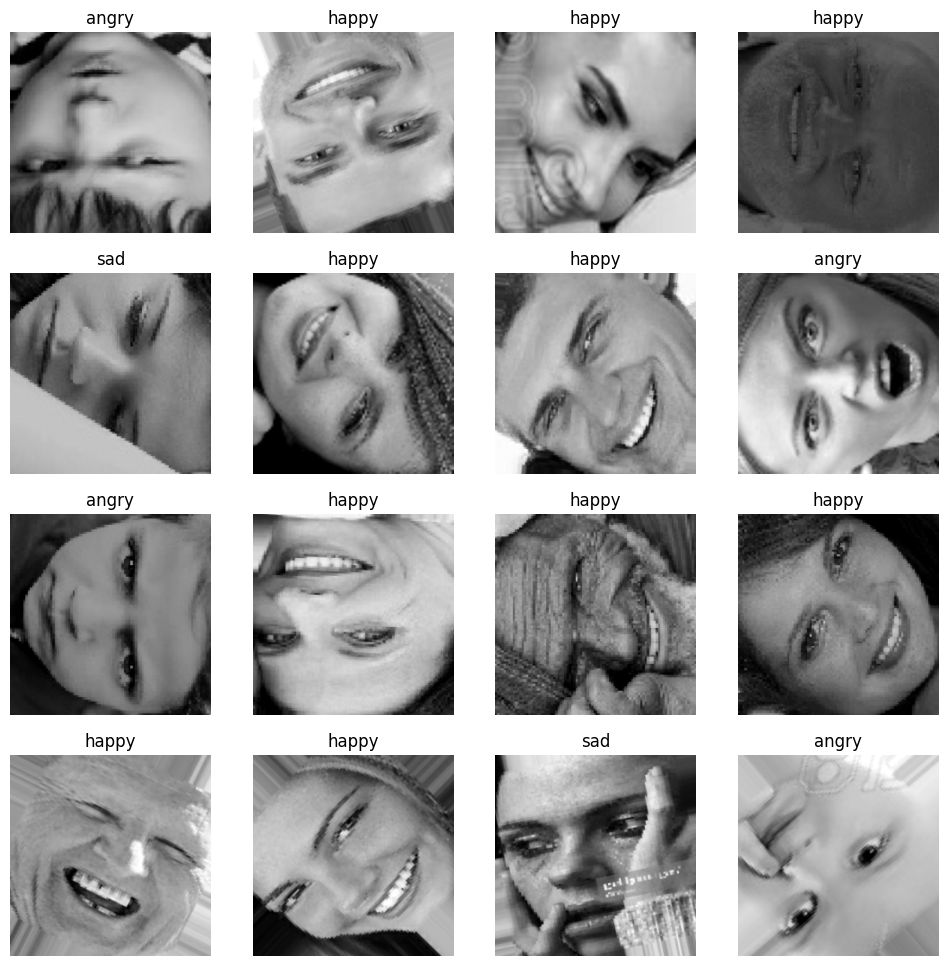

In [41]:
plt.figure(figsize=(12, 12))

for images, labels in train_augment_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
        plt.axis("off")

In [44]:
# tf.keras.layer Augment
augment_layers_limited_angle = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025),),
    RandomFlip(mode="horizontal",),
    RandomContrast(factor=0.1),
])

In [46]:
def augment_layer_limited(image, label):
    return augment_layers_limited_angle(image, training = True), label

Training with augment_layer_limited

In [49]:
train_limited_dataset = (
    train_dataset
    .map(augment_layer_limited, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

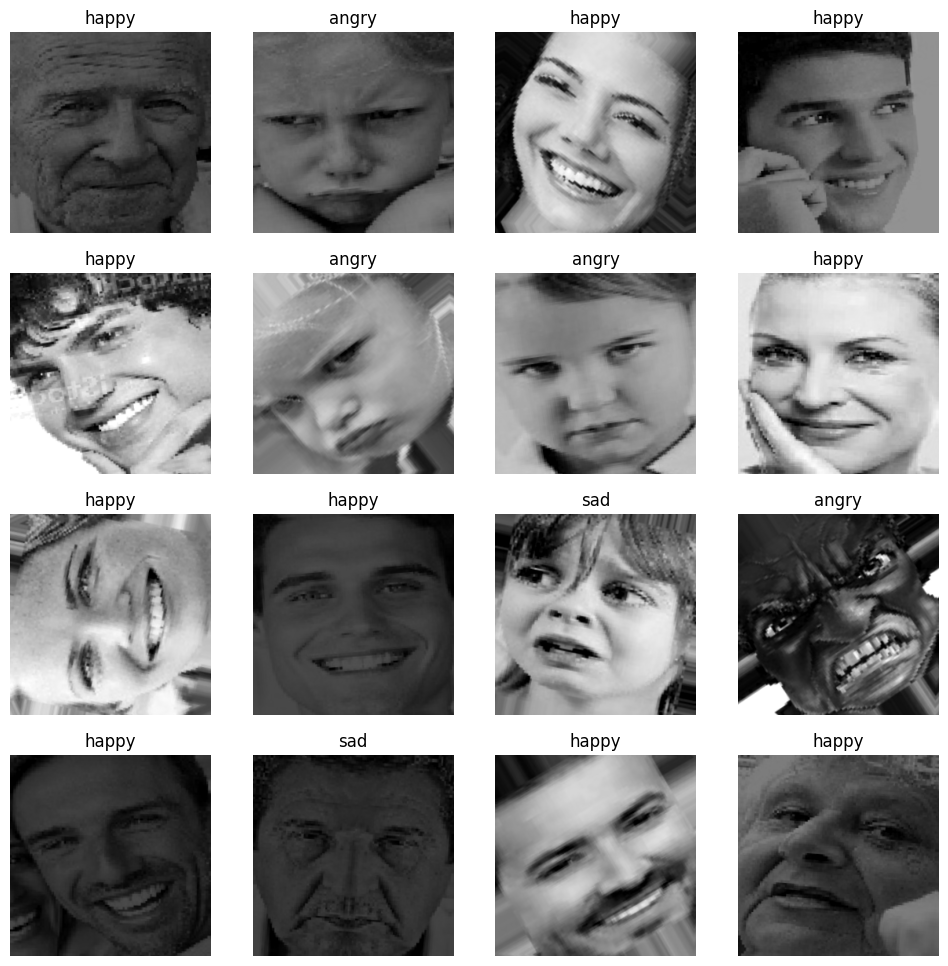

In [50]:
plt.figure(figsize=(12, 12))

for images, labels in train_limited_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
        plt.axis("off")

Cutmix Augmentation

In [53]:
IM_SIZE = 256
def box(lamda):

    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)

    r_w = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)
    r_h = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)

    r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
    r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

    x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
    y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

    r_w = x_b_r - r_x
    if (r_w == 0):
        r_w = 1
    r_h = y_b_r - r_y
    if (r_h == 0):
        r_h = 1

    return r_y, r_x, r_h, r_w 

In [55]:
def cutmix(train_dataset_1, train_dataset_2):
    
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]
    
    r_y, r_x, r_h, r_w = box(lamda)
    
    crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)

    pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

    crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)

    pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)
    image = image_1 - pad_1 + pad_2
    
    lamda = tf.cast(1 - (r_w * r_h) / (IM_SIZE * IM_SIZE), dtype=tf.float32)
    label = lamda * tf.cast(label_1, dtype=tf.float32) + (1 - lamda) * tf.cast(label_2, dtype=tf.float32)
    
    return image, label

In [57]:
train_dataset_1 = train_dataset.map(augment_layer_limited, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer_limited, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [59]:
train_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    #.prefetch(tf.data.AUTOTUNE)
)

# Dataset Preparation

In [61]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255.),
    
])

In [63]:
#train_dataset = (
    #train_dataset
    #.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
    #.prefetch(tf.data.AUTOTUNE)
#)

In [65]:
#train_dataset = (
    #train_dataset
    #.map(augment_layer_limited, num_parallel_calls=tf.data.AUTOTUNE)
    #.prefetch(tf.data.AUTOTUNE)
#)

In [67]:
train_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [68]:
validation_dataset = (
    val_dataset
    #.prefetch(tf.data.AUTOTUNE)
)

In [71]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [73]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# TFRecords

In [75]:
training_dataset = (
    train_dataset
    .unbatch()
)

In [77]:
validation_dataset = (
    val_dataset
    .unbatch()
)

In [79]:
def creat_example(image, label):

    bytes_feature = Feature(
        bytes_list = BytesList(value=[image])
    )

    int_feature = Feature(
        int64_list = Int64List(value=[label])
    )

    #float_feature = Feature(
        #float_list = FloatList(value=[1, 2, 3, 4])
    #)

    example = Example(
        features = Features(feature={
            "images":bytes_feature,
            "labels":int_feature,
            #"my_float":float_feature,
        })
    )
    
    return example.SerializeToString()

In [81]:
NUM_SHARDS = 10
PATH = r"E:\python\segmentation\DRIVE\Data\Emotions Dataset\tfrecords\shard_{:02d}.tfrecord"

In [27]:
#with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
   # for _ in range(4):
        #x, y = np.random.random(), np.random.random()

        #record_bytes = tf.train.Example(features=tf.train.Features(feature={
            #"x":tf.train.Feature(float_list=tf.train.FloatList(value=[x])),
            #"y":tf.train.Feature(float_list=tf.train.FloatList(value=[y])),
        #})).SerializeToString()

        #file_writer.write(record_bytes)

In [27]:
def encode_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image = tf.io.encode_jpeg(image)
    return image, tf.argmax(label)

In [28]:
PATH = r"E:\python\segmentation\DRIVE\Data\Emotions Dataset\tfrecords"

In [29]:
encoded_dataset = (
    training_dataset
    .map(encode_image)
)

In [31]:
#for shard_number in range(NUM_SHARDS):
    
    #sharded_dataset = (
       # encoded_dataset
        #.shard(num_shards=NUM_SHARDS, index=shard_number)
        #.as_numpy_iterator()
    #)

    #with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        
        #for encoded_image, encoded_label in sharded_dataset:
            #example = creat_example(encoded_image, encoded_label)
            #file_writer.write(example)

In [32]:
#l = [PATH.format(p) for p in range(NUM_SHARDS)]
#print(l)

In [30]:
recons_dataset = tf.data.TFRecordDataset(
    filenames=[[PATH.format(p) for p in range(NUM_SHARDS)]])

#val_recons_dataset = tf.data.TFRecordDataset(
    #filename = [PATH.format(p) for p in range(NUM_SHARDS - 2, NUM_SHARDS)])

In [31]:
def parse_tfracords(example):
    
    feature_description = {
        "images": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.io.decode_jpeg(example["images"], channels=3)
    
    return example["images"], example["labels"]

In [32]:
paresed_dataset = (
    recons_dataset
    .map(parse_tfracords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [34]:
#for i in paresed_dataset.take(1):
    #print(i)

# Modeling And Training

In [33]:
IM_SIZE = CONFIGURATION["IM_SIZE"]
DROPOUT_RATE = CONFIGURATION["DROPOUT_RATE"]
REGULARIZATION_RATE = CONFIGURATION["REGULARIZATION_RATE"]
N_FILTERS = CONFIGURATION["N_FILTERS"]
KERNEL_SIZE = CONFIGURATION["KERNEL_SIZE"]
POOL_SIZE = CONFIGURATION["POOL_SIZE"]
N_STRIDES = CONFIGURATION["N_STRIDES"]

In [34]:
IM_SIZE = 224

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layer,
    
    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid",
           activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
    
    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid",
           activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    
    Flatten(),
    
    Dense(CONFIGURATION["N_DENSE_1"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
    
    Dense(CONFIGURATION["N_DENSE_2"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    
    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")
])

#lenet_model.summary()

Training With augment_layer

In [35]:
lenet_1_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layer,
    
    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid",
           activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
    
    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid",
           activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    
    Flatten(),
    
    Dense(CONFIGURATION["N_DENSE_1"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
    
    Dense(CONFIGURATION["N_DENSE_2"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    
    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")
])

#lenet_model.summary()

Training with augment_layer_limited

In [36]:
lenet_2_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layer,
    
    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid",
           activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
    
    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid",
           activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    
    Flatten(),
    
    Dense(CONFIGURATION["N_DENSE_1"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
    
    Dense(CONFIGURATION["N_DENSE_2"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    
    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")
])

#lenet_model.summary()

Training with Cutmix function

In [37]:
# The model does not over fitting with these features

lenet_3_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layer,
    
    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid",
           activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
    
    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid",
           activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    
    Flatten(),
    
    Dense(CONFIGURATION["N_DENSE_1"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
    
    Dense(CONFIGURATION["N_DENSE_2"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    
    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")
])

#lenet_model.summary()

Model For TFRecord

In [38]:
# Model for TFRecord

lenet_4_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layer,
    Conv2D(filters=CONFIGURATION['N_FILTERS'], kernel_size=CONFIGURATION['KERNEL_SIZE'], strides=CONFIGURATION['N_STRIDES'],
          activation=tf.keras.activations.relu, kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES']*2),
    tf.keras.layers.Dropout(rate=CONFIGURATION['DROPOUT_RATE']),
    
    Conv2D(filters=CONFIGURATION['N_FILTERS'], kernel_size=CONFIGURATION['KERNEL_SIZE'], strides=CONFIGURATION['N_STRIDES'],
           activation=tf.keras.activations.relu, kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES']*2),
    Flatten(),
    tf.keras.layers.Dense(CONFIGURATION['N_DENSE_1'], activation=tf.keras.activations.relu, 
                         kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    tf.keras.layers.Dropout(CONFIGURATION['DROPOUT_RATE']),
    
    tf.keras.layers.Dense(CONFIGURATION['N_DENSE_2'], activation=tf.keras.activations.relu,
                         kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    tf.keras.layers.Dense(CONFIGURATION['NUM_CLASSES'], activation=tf.keras.activations.softmax)
])
    
lenet_4_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_16 (Ba  (None, 254, 254, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 6)      

# ResNet34

Custom Conv2D

In [39]:
class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding):
        super(CustomConv2D, self).__init__(name = 'custom_conv2D')
        
        self.conv = Conv2D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = 'relu',
            strides = n_strides,
            padding = padding
        )
        
        self.batch_norm = BatchNormalization()
        
    def call(self, x, training = True):
        x = self.conv(x)
        x = self.batch_norm(x, training)
        
        return x

ResidualBlock

In [40]:
n_strides = 1
dotted = (n_strides != 1)
dotted

False

In [41]:
class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides = 1):
        super(ResidualBlock, self).__init__(name = 'res_block')
        
        self.dotted = (n_strides != 1)
        
        self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = 'same')
        self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = 'same')
        
        self.activation = tf.keras.activations.relu
        
        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides, padding='same')
        
    def call(self, input, training):
        
        x = self.custom_conv_1(input, training)
        x = self.custom_conv_2(x, training)
        
        if self.dotted:
            x_add = self.custom_conv_3(input, training)
            x_add = tf.keras.layers.Add()([x, x_add])
            
        else:
            x_add = tf.keras.layers.Add()([x, input])
            
        return self.activation(x_add)

# Complete Network

In [42]:
# Got this information from paper
class ResNet34(Model):
    def __init__(self,):
        super(ResNet34, self,).__init__(name='resnet_34')
        
        self.conv_1 = CustomConv2D(64, 7, 2, padding='same')
        self.max_pool_1 = MaxPool2D(3, 2)
        
        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
        
        self.conv_3_1 = ResidualBlock(128, 2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)
        
        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)
        
        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)
        
        self.global_pool = GlobalAveragePooling2D()
        
        self.fc_3 = Dense(CONFIGURATION['NUM_CLASSES'], activation=tf.keras.activations.softmax)
        
    def call(self, x, training=True):
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        
        x = self.conv_2_1(x, training)
        x = self.conv_2_2(x, training)
        x = self.conv_2_3(x, training)
        
        x = self.conv_3_1(x, training)
        x = self.conv_3_2(x, training)
        x = self.conv_3_3(x, training)
        x = self.conv_3_4(x, training)
        
        x = self.conv_4_1(x, training)
        x = self.conv_4_2(x, training)
        x = self.conv_4_3(x, training)
        x = self.conv_4_4(x, training)
        x = self.conv_4_5(x, training)
        x = self.conv_4_6(x, training)
        
        x = self.conv_5_1(x, training)
        x = self.conv_5_2(x, training)
        x = self.conv_5_3(x, training)
        
        x = self.global_pool(x)
        
        return self.fc_3(x)

In [43]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1, 256, 256, 3]), training = True)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2D (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d_10 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

# Transfer Learning With EfficientNet

In [44]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    #input_tensor=None,
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    #pooling=None,
    #classes=3,
    #classifier_activation="softmax",
)

In [45]:
backbone.trainable = False

In [46]:
efficientnet_model = tf.keras.Sequential([
    Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION["N_DENSE_1"], activation="relu"), 
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"], activation="relu"), 
    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"), 
])

efficientnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              1836032   
                                                                 
 batch_normalization_56 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_17 (Dense)            (None, 128)               131200    
                                                      

# Fine Tuning EfficientNet

Functinal API

In [47]:
backbone.trainable = False

In [48]:
input_image = Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),

x = backbone(input_image, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION["N_DENSE_1"], activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(CONFIGURATION["N_DENSE_2"], activation="relu")(x) 
output = Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")(x) 

finetune_model = Model(input_image, output)

finetune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_19 (Dense)            (None, 1024)              1836032   
                                                                 
 batch_normalization_57 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                             

# Transfer Learning With VGG16

In [5]:
import tensorflow as tf
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    #weights="imagenet",
    #input_tensor=None,
    input_shape=(256, 256, 3),
    #pooling=None,
    #classes=1000,
    #classifier_activation="softmax"
)

vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [7]:
vgg_1_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights=None,
    #input_tensor=None,
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    #pooling=None,
    #classes=1000,
    #classifier_activation="softmax"
)

vgg_1_backbone.summary()

NameError: name 'CONFIGURATION' is not defined

Visualization hidden layers

In [51]:
def is_conv(layer_name):
    if "conv" in layer_name:
        return True
    
    else:
        return False

In [52]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)==True]

In [53]:
feature_1_maps = [layer.output for layer in vgg_1_backbone.layers[1:] if is_conv(layer.name)==True]

In [54]:
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
    
)

feature_map_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [55]:
feature_map_1_model = Model(
    inputs = vgg_1_backbone.input,
    outputs = feature_1_maps
    
)

feature_map_1_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [56]:
test_image = cv2.imread("E:\\python\\segmentation\\DRIVE\\Data\\Emotions Dataset\\Emotions Dataset\\test\\angry\\537380.jpg")

test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis=0)

#print(CLASS_NAMES[tf.argmax(efficientnet_model(im), axis=-1).numpy()[0]])

f_maps = feature_map_model.predict(im)

1/1 [==============================] - 0s 209ms/step


In [57]:
test_image = cv2.imread("E:\\python\\segmentation\\DRIVE\\Data\\Emotions Dataset\\Emotions Dataset\\test\\angry\\537380.jpg")

test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis=0)

#print(CLASS_NAMES[tf.argmax(efficientnet_model(im), axis=-1).numpy()[0]])

f_maps_1 = feature_map_1_model.predict(im)

1/1 [==============================] - 0s 171ms/step


In [58]:
print(len(f_maps))

13


In [59]:
print(len(f_maps_1))

13


In [60]:
for i in range(len(f_maps)):
    print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [61]:
for i in range(len(f_maps_1)):
    print(f_maps_1[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [62]:
#for i in range(len(f_maps)):
    #plt.figure(figsize=(256, 256))
    #f_size = f_maps[i].shape[1]
    #n_channles = f_maps[i].shape[3]
    
    #joint_maps = np.ones((f_size, f_size*n_channles))
    
    #axis = plt.subplot(len(f_maps), 1, i+1)
    #for j in range(n_channles):
        #joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]
        
    #plt.imshow(joint_maps[:,0:512])
    #plt.axis("off")

In [65]:
#for i in range(len(f_maps_1)):
    #plt.figure(figsize=(256, 256))
    #f_size_1 = f_maps_1[i].shape[1]
    #n_channles_1 = f_maps_1[i].shape[3]
    
    #joint_maps_1 = np.ones((f_size_1, f_size_1*n_channles_1))
    
    #axis = plt.subplot(len(f_maps_1), 1, i+1)
    #for j in range(n_channles_1):
        #joint_maps_1[:, f_size_1*j:f_size_1*(j+1)] = f_maps_1[i][..., j]
        
    #plt.imshow(joint_maps_1[:,0:512])
    #plt.axis("off")

GradCam

In [11]:
gradcam_backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

gradcam_backbone.trainablea = False

In [64]:
#input_size = Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))

x = gradcam_backbone.output

x = GlobalAveragePooling2D()(x)

x = Dense(CONFIGURATION["N_DENSE_1"], activation="relu")(x)

x = Dense(CONFIGURATION["N_DENSE_2"], activation="relu")(x)

output = Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")(x)

pretrained_model = Model(gradcam_backbone.input, output)
pretrained_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 256, 256, 3)          0         ['input_11[0][0]']            
                                                                                                  
 normalization_1 (Normaliza  (None, 256, 256, 3)          7         ['rescaling_3[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 256, 256, 3)          0         ['normalization_1[0][0]'

In [65]:
image_path = r"E:\python\segmentation\DRIVE\Data\Emotions Dataset\Emotions Dataset\train\happy\89555.jpg"

In [66]:
test_1_image = cv2.imread(image_path)

test_image = cv2.resize(test_1_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)

im_array = tf.expand_dims(im, axis=0)

#print(CLASS_NAMES[tf.argmax(efficientnet_model(im), axis=-1).numpy()[0]])

print(im_array.shape)


(1, 256, 256, 3)


In [67]:
pred = pretrained_model.predict(im_array)

1/1 [==============================] - 3s 3s/step


In [68]:
print(pred.shape)

(1, 3)


In [69]:
np.argmax(pred[0])

0

In [70]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(pretrained_model.inputs, last_conv_layer.output)

In [71]:
last_conv_layer_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 256, 256, 3)          0         ['input_11[0][0]']            
                                                                                                  
 normalization_1 (Normaliza  (None, 256, 256, 3)          7         ['rescaling_3[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 256, 256, 3)          0         ['normalization_1[0][0]'

In [72]:
classifier_layer_names = [
    "global_average_pooling2d_3",
    "dense_22",
    "dense_23",
    "dense_24"
]

In [73]:
classifier_input = Input(shape=(8, 8, 2048))
x = classifier_input
for layer_name in classifier_layer_names:
    x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [74]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(im_array)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    print(top_pred_index)
    top_class_channel = preds[:, top_pred_index]
    
grads = tape.gradient(top_class_channel, last_conv_layer_output)

tf.Tensor(0, shape=(), dtype=int64)


In [75]:
grads.shape

TensorShape([1, 8, 8, 2048])

In [76]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

In [77]:
print(pooled_grads.shape)

(2048,)


In [78]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [79]:
print(last_conv_layer_output.shape)

(8, 8, 2048)


In [80]:
heatmap = np.sum(last_conv_layer_output, axis = -1)

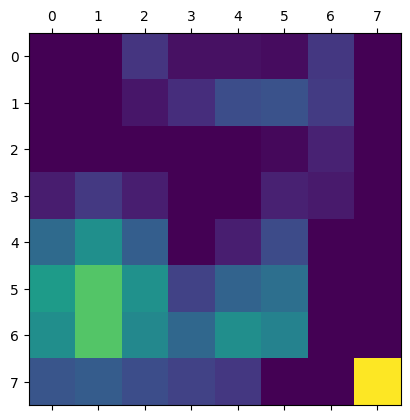

In [81]:
heatmap = tf.nn.relu(heatmap)
plt.matshow(heatmap)

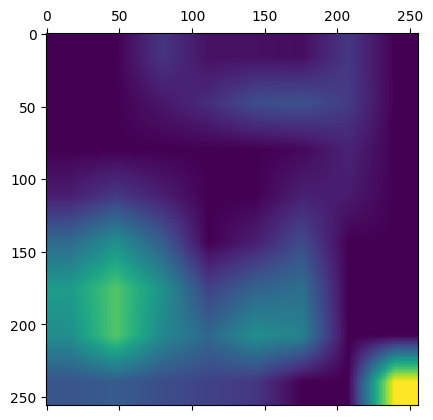

In [82]:
resizes_heatmap = cv2.resize(np.array(heatmap), (256, 256))
plt.matshow(resizes_heatmap)

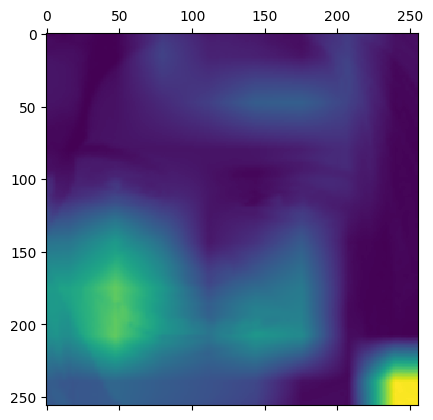

In [83]:
resizes_heatmap = cv2.resize(np.array(heatmap), (256, 256))
plt.matshow(resizes_heatmap*2555+im_array[0,:,:,0]/255)

# Vision Transformers

Patch Encoder

In [84]:
test_image_1 = cv2.imread(r"E:\python\segmentation\DRIVE\Data\Emotions Dataset\Emotions Dataset\test\sad\35028.jpg")
test_image_1 = cv2.resize(test_image_1, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

In [85]:
patches = tf.image.extract_patches(
    images=tf.expand_dims(test_image_1, axis=0),
    sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
    strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
    rates=[1, 1, 1, 1],
    padding="VALID"
)

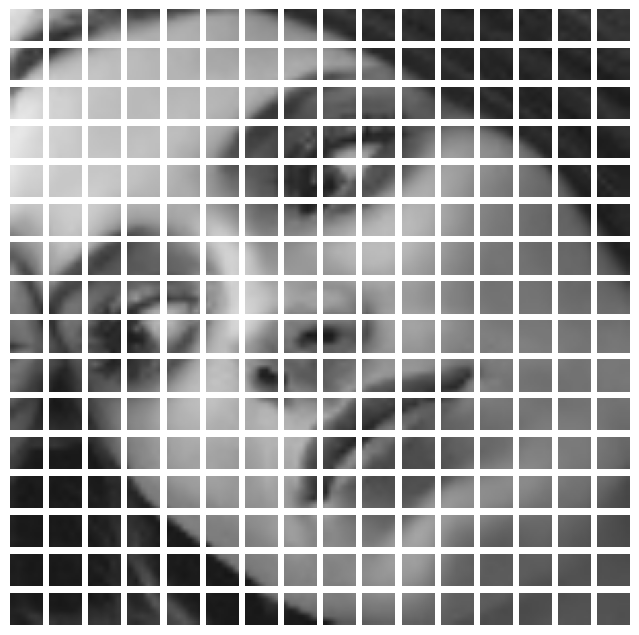

In [86]:
plt.figure(figsize=(8, 8))
k = 0

for i in range(16):
    for j in range(16):
        ax = plt.subplot(16, 16, k+1)
        plt.imshow(tf.reshape(patches[0, i, j,:], (16, 16, 3)))
        plt.axis("off")
        k += 1

In [87]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


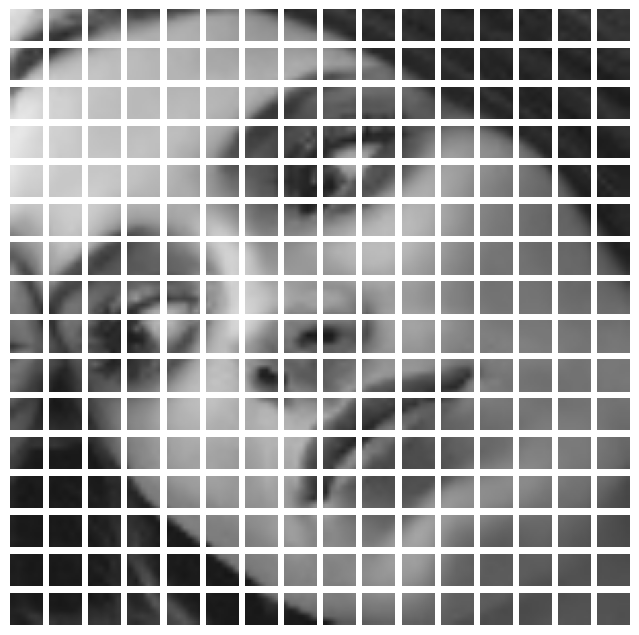

In [88]:
plt.figure(figsize=(8, 8))

for i in range(patches.shape[1]):
    ax = plt.subplot(16, 16, i+1)
    plt.imshow(tf.reshape(patches[0, i,:], (16, 16, 3)))
    plt.axis("off")

In [89]:
model = tf.keras.Sequential([
    Embedding(1000, 64, input_length=10)
])

# The model will take as input an integer matrix of size (batch,
# input_length), and the largest integer (i.e. word index) in the input
# should be no larger than 999 (vocabulary size).
# Now model.output_shape is (None, 10, 64), where "None" is the batch dimension.

input_array = np.random.randint(1000, size=(32, 10))
model.compile("rmsprop", "mse")
output_array = model.predict(input_array)
print(output_array.shape)

1/1 [==============================] - 0s 31ms/step
(32, 10, 64)


In [92]:
#model_1 = tf.keras.Sequential()
#model_1.add(Embedding(256, 768)) #input_length=10)

#input_array_1 = np.random.randint(1000, size=(1, 256))
#model_1.compile("rmsprop", "mse")
#output_array_1 = model_1.predict(input_array_1)
#print(output_array_1.shape)

In [90]:
class PatchEncoder(Layer):
    def __init__(self, N_PATCHES, HIDDEN_SIZE, ):
        super(PatchEncoder, self).__init__(name = 'patch_encodr_layer')
        
        self.linear_projection = Dense(HIDDEN_SIZE)
        self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)
        self.N_PATCHES = N_PATCHES
        
    def call(self, x):
        
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
            strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
)
        
       
        patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))
        embedding_input = tf.range(start=0, limit=self.N_PATCHES, delta=1)
        output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
        
        return output

In [91]:
patch_encoder = PatchEncoder(256, 768)
patch_encoder(tf.zeros([32, 256, 256, 3]))

<tf.Tensor: shape=(32, 256, 768), dtype=float32, numpy=
array([[[-0.00086432, -0.02087196,  0.03092336, ...,  0.008017  ,
          0.00977276, -0.01758937],
        [-0.04510127,  0.02756346, -0.0165931 , ...,  0.02208197,
          0.04188433, -0.01209502],
        [-0.00856422, -0.01011976, -0.04819443, ..., -0.0421775 ,
         -0.04994458, -0.02647132],
        ...,
        [-0.02140623, -0.03600732, -0.04821037, ...,  0.01901534,
          0.03513842,  0.0135041 ],
        [-0.02228664, -0.00825537, -0.00141478, ..., -0.02325431,
         -0.0244804 , -0.01215548],
        [ 0.00809715,  0.00880233, -0.0355005 , ...,  0.01253105,
          0.0042844 ,  0.01861416]],

       [[-0.00086432, -0.02087196,  0.03092336, ...,  0.008017  ,
          0.00977276, -0.01758937],
        [-0.04510127,  0.02756346, -0.0165931 , ...,  0.02208197,
          0.04188433, -0.01209502],
        [-0.00856422, -0.01011976, -0.04819443, ..., -0.0421775 ,
         -0.04994458, -0.02647132],
        ...

In [92]:
class TransformerEncoder(Layer):
    def __init__(self, N_HEADS, HIDDEN_SIZE):
        super(TransformerEncoder, self).__init__(name = 'transformer_encoder')
        
        self.layer_norm_1 = LayerNormalization()
        self.layer_norm_2 = LayerNormalization()
        
        self.multi_head_attention = MultiHeadAttention(N_HEADS, HIDDEN_SIZE)
         
        self.dense_1 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)                                                     
        self.dense_2 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)
        
        
    def call(self, input):
        
        x_1 = self.layer_norm_1(input)
        x_1 = self.multi_head_attention(x_1, x_1)
                                                       
        x_1 = Add()([x_1, input])
        
        x_2 = self.layer_norm_2(x_1)
        
        x_2 = self.dense_1(x_2)
        output = self.dense_2(x_2)

        output = Add()([output, x_1])
        
        return output

In [93]:
patch_encoder = TransformerEncoder(8, 768)
patch_encoder(tf.zeros([1, 256, 768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

# Buildding ViT Model From Scratch

In [94]:
# Got this information from paper
class ViT(Model):
    def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
        super(ViT, self,).__init__(name='vision_transformer')
        
        self.N_LAYERS = N_LAYERS
        self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
        self.transformer_encoders = [TransformerEncoder (N_HEADS, HIDDEN_SIZE)for _ in range(N_LAYERS)]
        self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
        self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
        self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")
        
    def call(self, input, training=True):
        
        x = self.patch_encoder(input)
        
        for i in range(self.N_LAYERS):
            x = self.transformer_encoders[i](x)
            
        x = Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        
        return self.dense_3(x)

In [95]:
vit = ViT(N_HEADS=4, HIDDEN_SIZE=768, N_PATCHES=256,
          N_LAYERS=2, N_DENSE_UNITS=128)
vit(tf.zeros([32, 256, 256, 3]))

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
       [0.41538242, 0.27314928, 0.31146824],
      

In [96]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encodr_layer (PatchE  multiple                  787200    
 ncoder)                                                         
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 dense_33 (Dense)            multiple                  25165952  
                                                                 
 dense_34 (Dense)            multiple                  16512     
                                                

In [97]:
checkpoint_callback = ModelCheckpoint(
    "best_weights",
    monitor="val_accuracy", 
    verbose=1,
    #save_best_only=True,
    save_weights_only=True,
    mode="max",
    #save_freq="epoch"
)

In [98]:
#metrics = [SparseCategoricalCrossentropy(name="accuracy")]
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

In [99]:
loss_function = CategoricalCrossentropy()#CategoricalCrossentropy()

In [100]:
vit.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics
)

In [101]:
# ViT model needs extra large dataset so i might not get good result
#vit_history = vit.fit(
    #train_dataset,
    #validation_data=validation_dataset,
    #epochs=1, #CONFIGURATION["N_EPOCHS"],
    #verbose=1,
    #class_weight=class_weight,
    #callbacks=[checkpoint_callback]
#)

# Hugging Face ViT

Fine Tuning Hugging Face ViTs

In [101]:
from transformers import ViTModel, ViTConfig

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig() # Can change the parameters from here

# Initializing a model from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [102]:
print(configuration)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.33.2"
}



# Training

In [103]:
from transformers import ViTFeatureExtractor, TFViTModel
from datasets import load_dataset
dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = feature_extractor(image, return_tensors="tf")
output = model(**inputs)

last_hidden_states = output.last_hidden_state
list(last_hidden_states.shape)

Using the latest cached version of the module from C:\Users\hamid\.cache\huggingface\modules\datasets_modules\datasets\huggingface--cats-image\68fbc793fb10cd165e490867f5d61fa366086ea40c73e549a020103dcb4f597e (last modified on Sat Oct  7 11:00:28 2023) since it couldn't be found locally at huggingface/cats-image., or remotely on the Hugging Face Hub.
C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


[1, 197, 768]

In [104]:
resize_rescale_hf = tf.keras.Sequential([
    Resizing(224, 224),
    Rescaling(1./255),
    Permute((3, 1, 2)),
    
])

Hugging Face Model

In [105]:
from transformers import ViTFeatureExtractor, TFViTModel

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape=(256, 256, 3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:,0,:]

output = Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")(x)

hf_model = tf.keras.Model(inputs=inputs, outputs=output)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [106]:
test_image_2 = cv2.imread(r"E:\python\segmentation\DRIVE\Data\Emotions Dataset\Emotions Dataset\test\sad\35028.jpg")
test_image_2 = cv2.resize(test_image_2, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

In [107]:
hf_model(tf.expand_dims(test_image_2, axis=0))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.39550787, 0.362834  , 0.24165814]], dtype=float32)>

In [108]:
hf_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_10 (Sequential)  (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0   

In [109]:
hf_model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=loss_function,
    metrics=metrics
)

In [113]:
#hf_history = hf_model.fit(
    #train_dataset,
    #validation_data=validation_dataset,
    #epochs=1, #CONFIGURATION["N_EPOCHS"],
    #verbose=1,
    #class_weight=class_weight,
    #callbacks=[WandbCallback(), LogConfMatrix()]
#)

Model Evaluation With Wandb

In [114]:
import wandb
from wandb.keras import WandbCallback

In [115]:
!wandb login 

wandb: Network error (ConnectionError), entering retry loop.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [131]:
wandb.init(project = "Emotion-Detection", )

In [132]:
wnadb.config = {
{'BATCH_SIZE':32,
    'IM_SIZE':256,
    'LEARNING_RATE':5e-5,
    "N_EPOCHS":20,
    'DROPOUT_RATE':0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS':6,
    'KERNEL_SIZE':3,
    'N_STRIDES':1,
    'POOL_SIZE':2,
    'PATCH_SIZE':16,
    'N_DENSE_1':1024,
    'N_DENSE_2':128,
    'NUM_CLASSES':3,
    'PROJ_DIM':768,
    'CLASS_NAMES':['angry', 'happy', 'sad']
}

CONFIGURATION = wandb.config

In [113]:
train_directory = "content/dataset/Emotions Dataset/Emotion Dataset/train"
test_directory = "content/dataset/Emotions Dataset/Emotion Dataset/test"

In [114]:
predicted = []
labels = []

for im, label in validation_dataset:
    predicted.append(pretrained_model(im))
    labels.append(label.numpy())

ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(256, 256, 3)

In [115]:
print(np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()]))

ValueError: attempt to get argmax of an empty sequence

In [136]:
#pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])

#lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()])

In [110]:
checkpoint_callback = ModelCheckpoint(
    "best_weights",
    monitor="val_accuracy", 
    verbose=1,
    #save_best_only=True,
    save_weights_only=True,
    mode="max",
    #save_freq="epoch"
)

In [111]:
class LogConfMatrix(Callback):
    def on_epoch_end(self, opoch, logs):
        predicted = []
        labels = []

        for im, label in validation_dataset:
            predicted.append(pretrained_model(im))
            labels.append(label.numpy())
            
        pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])

        lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()])
        
        cm = wnadb.plot.confusion_matrix(
            y_true = lab,
            preds = pred,
            class_names = CONFIGURATION["CLASS_NAMES"]
        )
        
        wandb.log({"conf_mat":cm})

In [112]:
class LogResultsTable(Callback):
    def on_epoch_end(self, epoch, logs):
        columns = ["image", "Predicted", "Label"]
        
        val_table = wandb.Table(columns = columns)
        
        for im, label in validation_dataset.take(25):
            
            pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(im), axis=-1).numpy()[0]]
            label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis=-1).numpy()[0]]
            
            row = [wandb.Image(im), pred, label]
            
            val_table.add_data(*row)
            
        wandb.log({"Model Results":val_table})

In [113]:
base_1_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs_1 = Input(shape=(256, 256, 3))
x_1 = resize_rescale_hf(inputs_1)
x_1 = base_model.vit(x_1)[0][:,0,:]

output_1 = Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")(x_1)

hf_wandb_model = tf.keras.Model(inputs=inputs_1, outputs=output_1)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [114]:
hf_wandb_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics
)

In [152]:
#hf_wandb_history = hf_wandb_model.fit(
    #train_dataset.take(20),
    #validation_data=validation_dataset,
    #epochs=3, #CONFIGURATION["N_EPOCHS"],
    #verbose=1,
    #class_weight=class_weight,
    #callbacks=[WandbCallback(), LogConfMatrix()]
#)

In [115]:
checkpoint_callback = ModelCheckpoint(
    "best_weights",
    monitor="val_accuracy", 
    verbose=1,
    #save_best_only=True,
    save_weights_only=True,
    mode="max",
    #save_freq="epoch"
)

In [116]:
#metrics = [SparseCategoricalCrossentropy(name="accuracy")]
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

In [117]:
loss_function = CategoricalCrossentropy()#CategoricalCrossentropy()

In [118]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
#Using "auto" / "sum_over_batch_size" reduction type
cce = tf.keras.losses.CategoricalCrossentropy()
print(cce(y_true, y_pred).numpy())

1.1769392


In [119]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.05, 0.85]]
#Using "auto" / "sum_over_batch_size" reduction type
cce = tf.keras.losses.CategoricalCrossentropy()
print(cce(y_true, y_pred).numpy())

0.1069061


 Compiling Models

In [120]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [121]:
lenet_1_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [122]:
lenet_2_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [123]:
lenet_3_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [124]:
lenet_4_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [125]:
resnet_34.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']*10),
    loss = loss_function,
    metrics = metrics
)

In [126]:
efficientnet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']/100),
    loss = loss_function,
    metrics = metrics,
    run_eagerly=True
)

In [127]:
feature_map_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']/100),
    loss = loss_function,
    metrics = metrics,
    run_eagerly=True
)

 Fitting Models

In [28]:
#history = lenet_model.fit(
    #train_dataset,
    #validation_data = validation_dataset,
    #epochs = 4, #CONFIGURATION["N_EPOCHS"],
    #verbose = 1
#)

In [33]:
history_1 = lenet_1_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 4, #CONFIGURATION["N_EPOCHS"],
    verbose = 1
)

Epoch 1/4
213/213 [==============================] - 187s 868ms/step - loss: 0.9806 - accuracy: 0.9800 - top_k_accuracy: 0.8249 - val_loss: 1.2200 - val_accuracy: 1.2217 - val_top_k_accuracy: 0.5650
Epoch 2/4
213/213 [==============================] - 185s 865ms/step - loss: 0.7524 - accuracy: 0.7521 - top_k_accuracy: 0.8867 - val_loss: 1.1325 - val_accuracy: 1.1327 - val_top_k_accuracy: 0.7305
Epoch 3/4
213/213 [==============================] - 185s 863ms/step - loss: 0.6221 - accuracy: 0.6223 - top_k_accuracy: 0.9223 - val_loss: 3.1396 - val_accuracy: 3.1462 - val_top_k_accuracy: 0.5645
Epoch 4/4
213/213 [==============================] - 184s 862ms/step - loss: 0.4655 - accuracy: 0.4647 - top_k_accuracy: 0.9491 - val_loss: 1.1674 - val_accuracy: 1.1585 - val_top_k_accuracy: 0.8099


In [49]:
history_2 = lenet_2_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 4, #CONFIGURATION["N_EPOCHS"],
    verbose = 1
)

Epoch 1/4
213/213 [==============================] - 190s 887ms/step - loss: 1.0264 - accuracy: 1.0260 - top_k_accuracy: 0.8009 - val_loss: 1.1921 - val_accuracy: 1.1928 - val_top_k_accuracy: 0.7678
Epoch 2/4
213/213 [==============================] - 192s 894ms/step - loss: 0.8752 - accuracy: 0.8748 - top_k_accuracy: 0.8481 - val_loss: 1.1059 - val_accuracy: 1.1085 - val_top_k_accuracy: 0.7928
Epoch 3/4
213/213 [==============================] - 192s 894ms/step - loss: 0.7854 - accuracy: 0.7845 - top_k_accuracy: 0.8812 - val_loss: 1.0930 - val_accuracy: 1.0962 - val_top_k_accuracy: 0.7502
Epoch 4/4
213/213 [==============================] - 192s 894ms/step - loss: 0.7222 - accuracy: 0.7220 - top_k_accuracy: 0.8998 - val_loss: 1.1502 - val_accuracy: 1.1472 - val_top_k_accuracy: 0.8055


In [67]:
history_3 = lenet_3_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 4, #CONFIGURATION["N_EPOCHS"],
    verbose = 1
)

Epoch 1/4
213/213 [==============================] - 220s 1s/step - loss: 1.0782 - accuracy: 1.0774 - top_k_accuracy: 0.7884 - val_loss: 1.1246 - val_accuracy: 1.1275 - val_top_k_accuracy: 0.7717
Epoch 2/4
213/213 [==============================] - 221s 1s/step - loss: 0.9723 - accuracy: 0.9723 - top_k_accuracy: 0.8222 - val_loss: 1.0604 - val_accuracy: 1.0601 - val_top_k_accuracy: 0.7950
Epoch 3/4
213/213 [==============================] - 220s 1s/step - loss: 0.9292 - accuracy: 0.9291 - top_k_accuracy: 0.8422 - val_loss: 1.1816 - val_accuracy: 1.1815 - val_top_k_accuracy: 0.7256
Epoch 4/4
213/213 [==============================] - 223s 1s/step - loss: 0.9073 - accuracy: 0.9077 - top_k_accuracy: 0.8488 - val_loss: 0.9809 - val_accuracy: 0.9785 - val_top_k_accuracy: 0.8108


In [64]:
#history_4 = lenet_4_model.fit(
    #train_dataset,
    #validation_data = validation_dataset,
    #epochs = 4, #CONFIGURATION["N_EPOCHS"],
   # verbose = 1
#)

In [63]:
#history_5 = resnet_34.fit(
    #train_dataset,
    #validation_data = validation_dataset,
    #epochs = 4, #CONFIGURATION["N_EPOCHS"],
    #verbose = 1,
   #callbacks=[checkpoint_callback]
#)

In [13]:
#history_6 = efficientnet_model.fit(
   # train_dataset.take(10),
   # validation_data = validation_dataset,
   # epochs = 4, #CONFIGURATION["N_EPOCHS"],
   # verbose = 1,
    #callbacks=[checkpoint_callback]
#)

In [155]:
history_7 = feature_map_model.fit(
    train_dataset.take(10),
    validation_data = validation_dataset,
    epochs = 4, #CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    #callbacks=[checkpoint_callback]
)

# Visualization

Visualization for lenet_model

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

Visualization for lenet_1_model

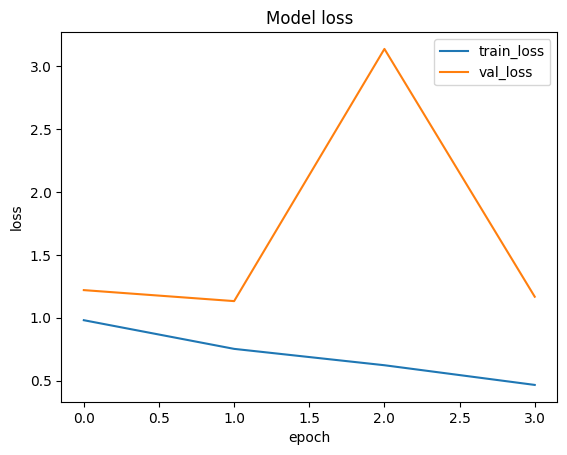

In [69]:
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

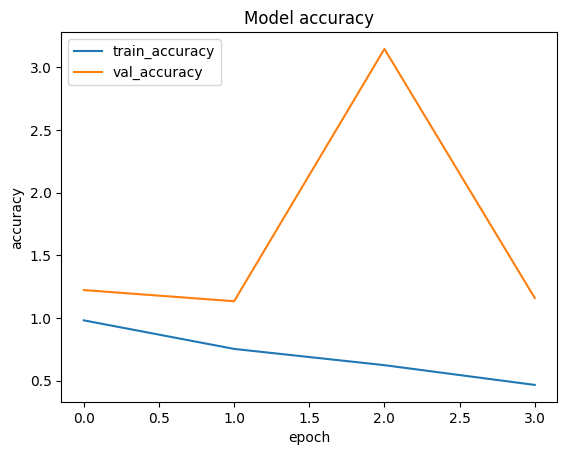

In [70]:
plt.plot(history_1.history["accuracy"])
plt.plot(history_1.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

Visualization for lenet_2_model

In [ ]:
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [ ]:
plt.plot(history_2.history["accuracy"])
plt.plot(history_2.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

Visualization for lenet_3_model

In [ ]:
plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [ ]:
plt.plot(history_3.history["accuracy"])
plt.plot(history_3.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

Visualization for resnet_34

In [ ]:
plt.plot(history_5.history["loss"])
plt.plot(history_5.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [ ]:
plt.plot(history_5.history["accuracy"])
plt.plot(history_5.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

Visualization for efficientnet

In [ ]:
plt.plot(history_6.history["loss"])
plt.plot(history_6.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [ ]:
plt.plot(history_6.history["accuracy"])
plt.plot(history_6.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [155]:
hf_model.save(r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\Onnx Format\vit_finetune")

INFO:tensorflow:Assets written to: E:\python\segmentation\DRIVE\Data\EmotionsDataset\Onnx Format\vit_finetune\assets


INFO:tensorflow:Assets written to: E:\python\segmentation\DRIVE\Data\EmotionsDataset\Onnx Format\vit_finetune\assets


# Exporting to Onnx format

Installation

In [157]:
#!pip install -U tf2onnx
#!pip install onnxruntime

Conversion

From Tensorflow SaveModel

In [4]:
!python -m tf2onnx.convet --saved-model vit_finetuned/ --output vit_onnx.onnx

C:\Users\hamid\anaconda3\envs\MachineLearning\python.exe: No module named tf2onnx.convet


In [ ]:
hf_model.save(r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\Onnx Format\vit_finetune.h5")

From Keras Model

In [128]:
import tf2onnx

spec = (tf.TensorSpec(
    (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    tf.float32, name="input"),)

output_path = r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\Onnx Format\vit_keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(hf_model, input_signature=spec, opset=13, output_path=output_path)

output_names = [n.name for n in model_proto.graph.output]

Could not search for non-variable resources. Concrete function internal representation may have changed.


In [129]:
print(output_names)

['dense_36']


In [130]:
output_names = ["dense_36"]

Inference

In [131]:
test_image = cv2.imread("E:\\python\\segmentation\\DRIVE\\Data\\Emotions Dataset\\Emotions Dataset\\train\\happy\\115103.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
#im = tf.constant(test_image, dtype = tf.float32)
test_image = test_image.astype(np.float32)

im = np.expand_dims(test_image, axis=0)

In [132]:
import time
provides = ["CPUExecurionProvider"]
m = rt.InferenceSession(output_path, providers=provides)

t1 = time.time()

onnx_pred = m.run(output_names, {"input":im})
print(time.time() - t1)

C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CPUExecurionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


EP Error Unknown Provider Type: CPUExecurionProvider when using ['CPUExecurionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
0.08349132537841797


In [133]:
print(onnx_pred)

[array([[0.34749287, 0.40122762, 0.2512795 ]], dtype=float32)]


In [134]:
import time

In [135]:
t1 = time.time()
hf_model(im)
print(time.time() - t1)

0.41715097427368164


In [136]:
rt.get_device()

'CPU'

In [137]:
provides = ["CUDAExecurionProvider"] #, "CPUExecurionProvider"]
m = rt.InferenceSession(output_path, providers=provides)

t1 = time.time()

N_PREDICTIONS = 100
for _ in range(100):
    onnx_pred = m.run(output_names, {"input":im})
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecurionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


EP Error Unknown Provider Type: CUDAExecurionProvider when using ['CUDAExecurionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
Time for a single Prediction 0.06984286308288574


In [138]:
print(onnx_pred)

[array([[0.34749287, 0.40122762, 0.2512795 ]], dtype=float32)]


In [139]:
t1 = time.time()
hf_model(im)
print(time.time() - t1)

0.40305423736572266


In [140]:
rt.get_device()

'CPU'

In [141]:
t1 = time.time()
for _ in range(100):
    hf_model(im)
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 0.39388022661209104


In [142]:
rt.get_device()

'CPU'

In [1]:
img_path = "E:\\python\\segmentation\\DRIVE\\Data\\Emotions Dataset\\Emotions Dataset\\train\\happy\\115103.jpg"

In [ ]:
providers = ["CPUExecurionProvider"]
m_q = rt.InferenceSession(r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\Onnx Format\vit_keras.onnx", providers=provides)

test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
im = np.float32(test_image)
img_array = np.expand_dims(im, axis=0)
print(img_array.shape)

emotion = ""
if np.argmax(onnx_pred[0][0]) == 0:
    emotion = "Angry"
    
elif np.argmax(onnx_pred[0][0]) == 1:
    emotion = "Happy"
    
else:
    emotion = "Sad"

In [4]:
def emotion_detector(im_array):
    
    if len(im_array.shape) == 2:
        im_array = cv2.cvtColor(im_array, cv2.COLOR_GRAY2RGB)

    providers = ["CPUExecurionProvider"]
    m_q = rt.InferenceSession(r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\Onnx Format\vit_keras.onnx", providers=provides)

    test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
    im = np.float32(test_image)
    img_array = np.expand_dims(im, axis=0)
    print(img_array.shape)

    emotion = ""
    if np.argmax(onnx_pred[0][0]) == 0:
        emotion = "Angry"

    elif np.argmax(onnx_pred[0][0]) == 1:
        emotion = "Happy"

    else:
        emotion = "Sad"
        
    return {"emotion":emotion}

In [ ]:
onnx_pred = m_q.run(["dense"], {"input":img_array})
print(np.argmax(onnx_pred[0][0]))

# Quantization In Tensorflow

In [143]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [139]:
model_fp32 = r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\Onnx Format\vit_keras.onnx"
model_quant = r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\vit_quantized.onnx"

quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)

Ignore MatMul due to non constant B: /[model_6/vit/encoder/layer_._0/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model_6/vit/encoder/layer_._0/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model_6/vit/encoder/layer_._1/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model_6/vit/encoder/layer_._1/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model_6/vit/encoder/layer_._2/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model_6/vit/encoder/layer_._2/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model_6/vit/encoder/layer_._3/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model_6/vit/encoder/layer_._3/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model_6/vit/encoder/layer_._4/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model_6/vit/encoder/layer_._4/attention/attention/MatMul_1]
Ignore MatMul due to

Evaluating The Model

In [144]:
def accuracy(model):
    total, acc = 0,0
    for im, label in validation_dataset.take(100):
        onnx_pred = model.run(output_names, {"input":np.array(tf.expand_dims(im, axis=0))})
        
        if (int(np.argmax(onnx_pred, axis=-1)[0][0]) == int(np.argmax(label, axis=-1)[0][0])):
            acc += 1
            
            total += 1
            
    return acc/total

In [15]:
provides = ["CPUExecutionProvider"]
m = rt.InferenceSession(r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\Onnx Format\vit_keras.onnx", providers=provides)
m_q = rt.InferenceSession(r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\vit_quantized.onnx", providers=provides)

print(accuracy(m))
print(accuracy(m_q))

In [148]:
# Testing For GPU
provides = ["CUDAExecutionProvider"] #, "CPUExecurionProvider"]
m = rt.InferenceSession(r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\vit_quantized.onnx", providers=provides)

t1 = time.time()

N_PREDICTIONS = 100
for _ in range(100):
    onnx_pred = m.run(output_names, {"input":im})
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Time for a single Prediction 0.056988797187805175


In [149]:
# Testing For CPU
provides = ["CPUExecutionProvider"] #, "CPUExecurionProvider"]
m = rt.InferenceSession(r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\vit_quantized.onnx", providers=provides)

t1 = time.time()

N_PREDICTIONS = 100
for _ in range(100):
    onnx_pred = m.run(output_names, {"input":im})
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 0.06013499975204468


# Quantization Aware Training

In [143]:
train_dataset_quant = (
    train_dataset
    .map(resize_rescale_layer)
)

In [144]:
pretrained_efficient_model = tf.keras.Sequential([
    InputLayer(input_shape=(256, 256, 3)),
   
    Conv2D(filters=CONFIGURATION['N_FILTERS'], kernel_size=CONFIGURATION['KERNEL_SIZE'], strides=CONFIGURATION['N_STRIDES'],
          activation=tf.keras.activations.relu, kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    #BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES']*2),
    tf.keras.layers.Dropout(rate=CONFIGURATION['DROPOUT_RATE']),
    
    Conv2D(filters=CONFIGURATION['N_FILTERS'], kernel_size=CONFIGURATION['KERNEL_SIZE'], strides=CONFIGURATION['N_STRIDES'],
           activation=tf.keras.activations.relu, kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    #BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES']*2),
    Flatten(),
    tf.keras.layers.Dense(CONFIGURATION['N_DENSE_1'], activation=tf.keras.activations.relu, 
                         kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    #BatchNormalization(),
    tf.keras.layers.Dropout(CONFIGURATION['DROPOUT_RATE']),
    
    tf.keras.layers.Dense(CONFIGURATION['N_DENSE_2'], activation=tf.keras.activations.relu,
                         kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    #BatchNormalization(),
    tf.keras.layers.Dense(CONFIGURATION['NUM_CLASSES'], activation=tf.keras.activations.softmax)
])
    

pretrained_efficient_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 254, 254, 6)       168       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 127, 127, 6)       0         
 ng2D)                                                           
                                                                 
 dropout_124 (Dropout)       (None, 127, 127, 6)       0         
                                                                 
 conv2d_47 (Conv2D)          (None, 125, 125, 6)       330       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 62, 62, 6)         0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 23064)           

In [145]:
quant_aware_hf = tfmot.quantization.keras.quantize_model(pretrained_efficient_model)

In [146]:
def apply_quantization_to_conv(layer):
    if "conv" in layer.name:
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [147]:
quant_aware_efficientnet = tf.keras.models.clone_model(
    pretrained_efficient_model, input_tensors=None, clone_function=apply_quantization_to_conv
)

In [148]:
quant_aware_efficientnet.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_annotate_10 (Quan  (None, 254, 254, 6)       168       
 tizeAnnotate)                                                   
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 127, 127, 6)       0         
 ng2D)                                                           
                                                                 
 dropout_124 (Dropout)       (None, 127, 127, 6)       0         
                                                                 
 quantize_annotate_11 (Quan  (None, 125, 125, 6)       330       
 tizeAnnotate)                                                   
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 62, 62, 6)         0         
 ng2D)                                               

In [149]:
quant_aware_model = tfmot.quantization.keras.quantize_model(quant_aware_efficientnet)
quant_aware_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (Quantize  (None, 256, 256, 3)       3         
 Layer)                                                          
                                                                 
 quant_conv2d_46 (QuantizeW  (None, 254, 254, 6)       183       
 rapperV2)                                                       
                                                                 
 quant_max_pooling2d_11 (Qu  (None, 127, 127, 6)       1         
 antizeWrapperV2)                                                
                                                                 
 quant_dropout_124 (Quantiz  (None, 127, 127, 6)       1         
 eWrapperV2)                                                     
                                                                 
 quant_conv2d_47 (QuantizeW  (None, 125, 125, 6)     

In [150]:
quant_aware_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="Top_K_Accuracy")],
    metrics = metrics,
    run_eagerly=True
)

In [151]:
#quantize_history = quant_aware_model.fit(
    #train_dataset,
    #validation_data=validation_dataset,
    #epochs=5,#*CONFIGURATION["N_EPOCHS"],
    #verbose=1
#)

In [17]:
#!pip install "fastapi[all]"

In [19]:
#!pip install "uvicorn[standard]"

# Post Training Quantization

In [152]:
#pretrained_efficient_model.load_weights()

In [157]:
#quant_aware_model.evaluate(validation_dataset)

In [154]:
def representative_data_generator():
    for input_value, j in train_dataset.take(20):
        yield [input_value]

In [158]:
converter = tf.lite.TFLiteConverter.from_keras_model(pretrained_efficient_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_generator

In [159]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\hamid\AppData\Local\Temp\tmpl6ug7fes\assets


INFO:tensorflow:Assets written to: C:\Users\hamid\AppData\Local\Temp\tmpl6ug7fes\assets
C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\tensorflow\lite\python\convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [161]:
import pathlib

tflite_model_dir = pathlib.Path(r"E:\python\segmentation\DRIVE\Data\EmotionsDataset")
tflite_model_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_model_dir/"eff_model.tflite"
tflite_model_file.write_bytes(tflite_model)

23754312

In [162]:
quant_aware_model.save("eff_model.h5")

C:\Users\hamid\anaconda3\envs\MachineLearning\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TFLite Runtime

In [23]:
#!pip install --extra-index-url https://google-coral.github.io/py.repo/ tflite_runtime

In [25]:
#!pip install tflite-runtime

#import tflite_runtime

In [3]:
#import tflite_runetime_interpreter as tflite # When tensorflow is imported I get an error so I change it
import tflite_runtime as tflite

In [167]:
test_image_lite = cv2.imread("E:\\python\\segmentation\\DRIVE\\Data\\Emotions Dataset\\Emotions Dataset\\train\\happy\\115103.jpg")
test_image_lite = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
print(test_image_lite.dtype)

#im_lite = tf.constant(test_image_lite, dtype = tf.float32)

im_lite = np.expand_dims(test_image_lite, axis=0)

#print(CONFIGURATION["CLASS_NAMES"][tf.argmax(quant_aware_model(im_lite), axis=-1).numpy()[0]])

uint8


In [ ]:
interpreter = tflite.Interpreter(model_path=r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\eff_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_inputt_details()[0]
output_details = interpreter.get_output_details()[0]

print(input_details["dtype"])

#test_image = im_lite.numpy().astype(input_details["dtype"])
#interpreter.set_tensor(input_details["index"], test_image)

#interpreter.invoke()

#output = interpreter.get_tensor(output_details["index"])[0]

In [ ]:
interpreter = tflite.Interpreter(model_path=r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\eff_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_inputt_details()[0]
output_details = interpreter.get_output_details()[0]

test_image = im_lite.numpy().astype(input_details["dtype"]) # I have done this allready but just do it again with this method
print(input_details["index"])
interpreter.set_tensor(input_details["index"], test_image)

interpreter.invoke()

output = interpreter.get_tensor(output_details["index"])[0]

In [ ]:
print(CONFIGURATION["CLASS_NAMES"][np.argmax(output)])

In [171]:
model_path = r"E:\python\segmentation\DRIVE\Data\EmotionsDataset\eff_model.tflite"

In [170]:
def accuracy_of_tflite(model_path):
    total, correct = 0,0
    interpreter = tf.lite.Interpreter(model_path=model_path)
    
    input_detalis = interpreter.get_input_details()[0]
    output_detalis = interpreter.get_output_details()[0]
    
    for im, label in validation_dataset.take(100): # To get heig
        
        test_image = im.numpy().astype(input_detalis["dtype"])
        
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_detalis["index"])[0]
        
        if(int(np.argmax(output)) == int(np.argmax(label, axis=-1)[0])):
            correct += 1 
            
        total += 1
    return correct/total

In [ ]:
accuracy_of_tflite(model_path=model_path)

# Evaluation

In [ ]:
lenet_model.evaluate(validation_dataset)

In [ ]:
lenet_1_model.evaluate(validation_dataset)

In [ ]:
lenet_2_model.evaluate(validation_dataset)

In [ ]:
resnet_34.load_weights("best_weights")

In [ ]:
resnet_34.evaluate(validation_dataset)

In [ ]:
efficientnet_model.load_weights("best_weights")

In [ ]:
efficientnet_model.evaluate(validation_dataset)

# Testing

In [ ]:
test_image = cv2.imread("E:\\python\\segmentation\\DRIVE\\Data\\Emotions Dataset\\Emotions Dataset\\train\\happy\\115103.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis=0)

print(CLASS_NAMES[tf.argmax(lenet_model(im), axis=-1).numpy()[0]])

In [ ]:
for i in validation_dataset.take(1):
    print(i)

In [165]:
test_image = cv2.imread("E:\\python\\segmentation\\DRIVE\\Data\\Emotions Dataset\\Emotions Dataset\\test\\angry\\537380.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis=0)

print(hf_model(im))
print(CLASS_NAMES[tf.argmax(efficientnet_model(im), axis=-1).numpy()[0]])

tf.Tensor([[0.34242758 0.34931883 0.30825356]], shape=(1, 3), dtype=float32)
sad


In [ ]:
plt.figure(figsize=(12, 12))

for images, labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(" True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()] + "\n" + "Predicted Label - :" + CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0]])
        plt.axis("off")

In [ ]:
plt.figure(figsize=(12, 12))

for images, labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(" True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()]
                  + "\n" + "Predicted Label - :"
                  + CLASS_NAMES[tf.argmax(lenet_1_model(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0]])
        plt.axis("off")

In [ ]:
plt.figure(figsize=(12, 12))

for images, labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(" True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()] + "\n" + "Predicted Label - :" + CLASS_NAMES[tf.argmax(lenet_2_model(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0]])
        plt.axis("off")

In [ ]:
plt.figure(figsize=(12, 12))

for images, labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(" True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()] + "\n" + "Predicted Label - :" + CLASS_NAMES[tf.argmax(lenet_3_model(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0]])
        plt.axis("off")

# Confusion Matrix

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()]))

In [ ]:
print(np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()]))

In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])

lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()])

In [ ]:

cm = confusion_matrix(lab, pred)

print(cm)

plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True)
plt.title("Confusion metrix")
plt.ylabel("Actual")
plt.xlabel("predicted")